## First get all boroughs and neighborhoods onto a map of Ontario 

In [1]:
# import all needed utilities and modules
import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

In [2]:
# load neighborhoods and boroughs data in from webscraping url page with BeautifulSoup
import lxml.html as lh
from bs4 import BeautifulSoup

website_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
res = requests.get(website_url)
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 

# Fetch table content into a dataframe:
df = pd.read_html(str(table))[0]

# Format the dataframe with the required column headings and reindex the rows:
df.columns = df.iloc[0]
df = df.reindex(df.index.drop(0)).reset_index(drop=True)
df.columns.name = None

# Remove rows with 'Not assigned' Borough:
df = df[df.Borough != 'Not assigned']
# Replace 'Not assigned' Neighbourhood to 'Borough name'
df.loc[df['Neighbourhood'] =='Not assigned', 'Neighbourhood'] = df['Borough']
df.reset_index( drop=True, inplace=True)

df.head()


,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [3]:
# import the csv file with the latitude and longitude coordinates corresponding to postal code as dataframe df2
url = 'https://cocl.us/Geospatial_data'
df2 = pd.read_csv(url)
df2.columns = ['Postcode', 'Latitude','Longitude']
df2.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [4]:
# merge df and df2 on PostalCode
df_merge = pd.merge(df, df2, on='Postcode')
df_merge.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


In [5]:
df_merge.shape

(211, 5)

## Create map of Toronto 

In [6]:
# Get geographical coordinates of Ontario
from geopy.geocoders import Nominatim 
address = 'Toronto, Ontario'
geolocator = Nominatim(user_agent = 'ont_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print ('The geographical coordinates of Toronto are {},{}.'.format(latitude,longitude))

The geographical coordinates of Toronto are 43.653963,-79.387207.


In [7]:
# Create map of Toronto
!pip install folium
import folium
map_toronto = folium.Map( location=[latitude,longitude], zoom_start =11)
map_toronto

tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.


In [8]:
for lat, lng, label in zip(df_merge['Latitude'], df_merge['Longitude'],df_merge['Neighbourhood']):
    label= folium.Popup(label, parse_html = True)
    folium.CircleMarker([lat,lng],
                       radius =5,
                       popup = label,
                       color='blue',
                       fill =True,
                       fill_color = '#3186cc',
                       fill_opacity = 0.7,
                       parse_html = False).add_to(map_toronto)
map_toronto

In [9]:
# Count the number of boroughs and neighborhoods
number_borough = df_merge['Borough'].nunique()
number_neighborhood = len(df_merge['Neighbourhood'])
print('There are {} boroughs and {} Neighborhoods in Toronto area.'. format((number_borough),number_neighborhood))

There are 11 boroughs and 211 Neighborhoods in Toronto area.


## Use Foursquare API to explore the neighbourhoods

In [10]:
# @hidden_cell
CLIENT_ID ='U5BMNK0AWH3GX3HECO5FWTKV4RYYOKPYWMILJNL3LYGMCX2V'
CLIENT_SECRET = '40SPFPTH2VO0XS40IDJ4LJPEBZJ4I31CZGADB2GNV4OK0A00'
VERSION ='20180605'

print('Your Credentials: ')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

Your Credentials: 
CLIENT_ID: U5BMNK0AWH3GX3HECO5FWTKV4RYYOKPYWMILJNL3LYGMCX2V
CLIENT_SECRET: 40SPFPTH2VO0XS40IDJ4LJPEBZJ4I31CZGADB2GNV4OK0A00


## explore first neighbourhood

In [11]:
# get neighborhood name
df_merge.loc[0, 'Neighbourhood']

'Parkwoods'

In [12]:
# get neighbourhood latitude and longitude
neighborhood_latitude = df_merge.loc[0,'Latitude']
neighborhood_longitude = df_merge.loc[0,'Longitude']
neighborhood_name = df_merge.loc[0,'Neighbourhood']
print('Latitude and Longitude values of {} are {},{}.'.format (neighborhood_name, neighborhood_latitude, neighborhood_longitude ))

Latitude and Longitude values of Parkwoods are 43.7532586,-79.3296565.


In [13]:
# create get results url
LIMIT =100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
       CLIENT_ID,
       CLIENT_SECRET,
       VERSION,
       neighborhood_latitude,
       neighborhood_longitude,
       radius,
       LIMIT )
url

'https://api.foursquare.com/v2/venues/explore?client_id=U5BMNK0AWH3GX3HECO5FWTKV4RYYOKPYWMILJNL3LYGMCX2V&client_secret=40SPFPTH2VO0XS40IDJ4LJPEBZJ4I31CZGADB2GNV4OK0A00&v=20180605&ll=43.7532586,-79.3296565&radius=500&limit=100'

In [14]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ced5234351e3d128971ca34'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4e8d9dcdd5fbbbb6b3003c7b-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d163941735',
         'name': 'Park',
         'pluralName': 'Parks',
         'primary': True,
         'shortName': 'Park'}],
       'id': '4e8d9dcdd5fbbbb6b3003c7b',
       'location': {'address': 'Toronto',
        'cc': 'CA',
        'city': 'Toronto',
        'country': 'Canada',
        'distance': 245,
        'formattedAddress': ['Toronto', 'Toronto ON', 'Canada'],
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.751976046055574,
          'lng': -79.33214044722958}],
        'lat

In [15]:
#create function that extracts category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list)==0:
        return None
    else:
        return categories_list[0]['name']

In [16]:
# clean json and structure to DataFrame
from pandas.io.json import json_normalize
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
#filter columns
filtered_columns = ['venue.name', 'venue.categories','venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[ : , filtered_columns]
#filter category
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
#clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,KFC,Fast Food Restaurant,43.754387,-79.333021
2,Variety Store,Food & Drink Shop,43.751974,-79.333114


In [17]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

3 venues were returned by Foursquare.


In [18]:
#Define function to get top 100 Nearby Venues (within 500 metres radius) for all neighborhoods in Toronto

def getNearbyVenues( names, latitudes, longitudes, radius=500 ):
    
    venues_list = []
    
    for name, lat, lng in zip(names,latitudes, longitudes):
        print(name)
   
    #create the API request URL:
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(   
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
    # make the get requests
        results = requests.get(url).json()["response"]['groups'][0]['items']
    # return only relevant information for each nearby venue
        venues_list.append([(
                        name,
                        lat,
                        lng,
                        v['venue']['name'],
                        v['venue']['location']['lat'],
                        v['venue']['location']['lng'],
                        v['venue']['categories'][0]['name']) for v in results])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                             'Neighbourhood Latitude',
                             'Neighbourhood Longitude',
                             'Venue',
                             'venue Latitude',
                             'Venue Longitude',
                             'Venue Category']
    return(nearby_venues)          

In [19]:
# create a new dataframe by running function above for each neighborhood and called it toronto_venues
toronto_venues = getNearbyVenues( names = df_merge['Neighbourhood'],latitudes = df_merge['Latitude'],longitudes = df_merge['Longitude'])

Parkwoods
Victoria Village
Harbourfront
Regent Park
Lawrence Heights
Lawrence Manor
Queen's Park
Islington Avenue
Rouge
Malvern
Don Mills North
Woodbine Gardens
Parkview Hill
Ryerson
Garden District
Glencairn
Cloverdale
Islington
Martin Grove
Princess Gardens
West Deane Park
Highland Creek
Rouge Hill
Port Union
Flemingdon Park
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens
Eringate
Markland Wood
Old Burnhamthorpe
Guildwood
Morningside
West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor
Downsview North
Wilson Heights
Thorncliffe Park
Adelaide
King
Richmond
Dovercourt Village
Dufferin
Scarborough Village
Fairview
Henry Farm
Oriole
Northwood Park
York University
East Toronto
Harbourfront East
Toronto Islands
Union Station
Little Portugal
Trinity
East Birchmount Park
Ionview
Kennedy Park
Bayview Village
CFB Toronto
Downsview East
The Danforth West
Riverdale
Design E

In [20]:
print(toronto_venues.shape)
toronto_venues.head()

(4423, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [21]:
# check how many venues were returned for each neighborhood
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Adelaide,100,100,100,100,100,100
Agincourt,6,6,6,6,6,6
Agincourt North,3,3,3,3,3,3
Albion Gardens,10,10,10,10,10,10
Alderwood,11,11,11,11,11,11
Bathurst Manor,20,20,20,20,20,20
Bathurst Quay,14,14,14,14,14,14
Bayview Village,4,4,4,4,4,4
Beaumond Heights,10,10,10,10,10,10


In [22]:
# find how many unique categories are there returned from all the venues
print('There are {} unique categories found.'.format(len(toronto_venues['Venue Category'].unique())))

There are 279 unique categories found.


## Analyze each neighbourhood

In [23]:
# use one hot encoding to apply venue category as a feature for each venue
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix ="", prefix_sep = "")
# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood']
# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[ : -1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# find out size of toronto_onehot dataframe
toronto_onehot.shape

(4423, 280)

In [25]:
# group rows by neighborhood and take mean frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Adelaide,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.010000,0.000000,0.00,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000
1,Agincourt,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Agincourt North,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Albion Gardens,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Alderwood,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Bathurst Manor,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Bathurst Quay,0.0,0.000000,0.000000,0.071429,0.071429,0.071429,0.142857,0.214286,0.071429,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Bayview Village,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Beaumond Heights,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Bedford Park,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
# check the size of toronto_grouped
toronto_grouped.shape

(205, 280)

In [27]:
# print out each neighborhood and its top 5 most common venues
num_top_venues = 5
for hood in toronto_grouped['Neighbourhood']:
    print("---" + hood + "---")
    temp = toronto_grouped[toronto_grouped['Neighbourhood']==hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq':2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---Adelaide---
                 venue  freq
0          Coffee Shop  0.06
1                 Café  0.05
2  American Restaurant  0.04
3                  Bar  0.04
4      Thai Restaurant  0.04


---Agincourt---
            venue  freq
0  Sandwich Place  0.17
1  Breakfast Spot  0.17
2    Skating Rink  0.17
3          Lounge  0.17
4      Print Shop  0.17


---Agincourt North---
               venue  freq
0         Playground  0.33
1             Bakery  0.33
2               Park  0.33
3  Accessories Store  0.00
4  Mobile Phone Shop  0.00


---Albion Gardens---
                 venue  freq
0        Grocery Store   0.2
1             Pharmacy   0.1
2          Video Store   0.1
3       Sandwich Place   0.1
4  Fried Chicken Joint   0.1


---Alderwood---
            venue  freq
0     Pizza Place  0.18
1        Pharmacy  0.09
2    Dance Studio  0.09
3  Sandwich Place  0.09
4    Skating Rink  0.09


---Bathurst Manor---
                venue  freq
0         Coffee Shop  0.10
1         Bridal Shop  0.

## Cast this to a DataFrame

In [28]:
# create function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
#create dataframe and display the top ten venues for each neighborhood

num_top_venues = 10
indicators = ['st','nd','rd']
# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
#create new DataFrame
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Café,Steakhouse,Thai Restaurant,Bar,American Restaurant,Cosmetics Shop,Hotel,Burger Joint,Bakery
1,Agincourt,Print Shop,Lounge,Skating Rink,Breakfast Spot,Sandwich Place,Chinese Restaurant,Yoga Studio,Discount Store,Dog Run,Doner Restaurant
2,Agincourt North,Park,Playground,Bakery,Yoga Studio,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
3,Albion Gardens,Grocery Store,Pharmacy,Video Store,Sandwich Place,Beer Store,Coffee Shop,Fried Chicken Joint,Pizza Place,Fast Food Restaurant,Electronics Store
4,Alderwood,Pizza Place,Dance Studio,Sandwich Place,Skating Rink,Gym,Coffee Shop,Pharmacy,Athletics & Sports,Pool,Pub


## Cluster neighbourhoods


In [30]:
# Apply KMeans Clustering algorithm to cluster neighborhoods
# in view of sample size, try three clusters

from sklearn.cluster import KMeans

kclusters = 3
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(toronto_grouped_clustering)
#check cluster labels
kmeans.labels_[0:10]

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [31]:
# create a new Dataframe to include the cluster as well as the top ten venues for each neighborhood
# add clustering labels
neighbourhoods_venues_sorted.insert(loc = 0, column = 'Cluster Labels', value = kmeans.labels_ , allow_duplicates = False)
toronto_merged = df_merge
# merge dfs to add lat and long data
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood', how ='right')
toronto_merged.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,1,Fast Food Restaurant,Park,Food & Drink Shop,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
1,M4A,North York,Victoria Village,43.725882,-79.315572,1,Intersection,Hockey Arena,Coffee Shop,Portuguese Restaurant,Pizza Place,Event Space,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,1,Coffee Shop,Bakery,Park,Pub,Breakfast Spot,Restaurant,Café,Mexican Restaurant,Theater,Beer Store
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636,1,Coffee Shop,Bakery,Park,Pub,Breakfast Spot,Restaurant,Café,Mexican Restaurant,Theater,Beer Store
4,M6A,North York,Lawrence Heights,43.718518,-79.464763,1,Women's Store,Accessories Store,Event Space,Miscellaneous Shop,Clothing Store,Coffee Shop,Furniture / Home Store,Vietnamese Restaurant,Boutique,Ethiopian Restaurant


In [32]:
print(kmeans.labels_)

[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 2 1 1 0 1 1 1 1
 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 2 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]


In [33]:
toronto_merged.dtypes

Postcode                   object
Borough                    object
Neighbourhood              object
Latitude                  float64
Longitude                 float64
Cluster Labels              int32
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

## create map to show clusters

In [34]:
#create map
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import rgb2hex
import matplotlib.cm as cm
map_clusters = folium.Map(location=[latitude,longitude], zoom_start =11)

# set color scheme for clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0,1,len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#add markers to map
markers_color = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + 'Cluster'+ str(cluster), parse_html = True)
    folium.CircleMarker(
            [lat,lon],
            radius = 5,
            popup = label,
            color = rainbow [cluster -1],
            fill = True,
            fill_color = rainbow [cluster -1],
            fill_opacity = 0.7). add_to (map_clusters)
            
map_clusters

## Examine each of the three clusters

In [35]:
# look at cluster 1
toronto_merged.loc[toronto_merged['Cluster Labels']==0,toronto_merged.columns[[1]+ list(range(5,toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
54,Scarborough,0,Playground,Yoga Studio,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
60,East York,0,Park,Coffee Shop,Convenience Store,Yoga Studio,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
89,North York,0,Park,Bakery,Construction & Landscaping,Basketball Court,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore
90,North York,0,Park,Bakery,Construction & Landscaping,Basketball Court,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore
91,North York,0,Park,Bakery,Construction & Landscaping,Basketball Court,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore
116,York,0,Park,Convenience Store,Yoga Studio,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
150,Central Toronto,0,Restaurant,Playground,Yoga Studio,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore
151,Central Toronto,0,Restaurant,Playground,Yoga Studio,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore
155,Scarborough,0,Park,Playground,Bakery,Yoga Studio,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
156,Scarborough,0,Park,Playground,Bakery,Yoga Studio,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop


In [36]:
# look at cluster 2
toronto_merged.loc[toronto_merged['Cluster Labels']==1, toronto_merged.columns[[1] + list(range(5,toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,1,Fast Food Restaurant,Park,Food & Drink Shop,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
1,North York,1,Intersection,Hockey Arena,Coffee Shop,Portuguese Restaurant,Pizza Place,Event Space,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
2,Downtown Toronto,1,Coffee Shop,Bakery,Park,Pub,Breakfast Spot,Restaurant,Café,Mexican Restaurant,Theater,Beer Store
3,Downtown Toronto,1,Coffee Shop,Bakery,Park,Pub,Breakfast Spot,Restaurant,Café,Mexican Restaurant,Theater,Beer Store
4,North York,1,Women's Store,Accessories Store,Event Space,Miscellaneous Shop,Clothing Store,Coffee Shop,Furniture / Home Store,Vietnamese Restaurant,Boutique,Ethiopian Restaurant
5,North York,1,Women's Store,Accessories Store,Event Space,Miscellaneous Shop,Clothing Store,Coffee Shop,Furniture / Home Store,Vietnamese Restaurant,Boutique,Ethiopian Restaurant
6,Queen's Park,1,Coffee Shop,Japanese Restaurant,Park,Sushi Restaurant,Gym,Fast Food Restaurant,Portuguese Restaurant,Smoothie Shop,Seafood Restaurant,Sandwich Place
8,Scarborough,1,Fast Food Restaurant,Yoga Studio,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
9,Scarborough,1,Fast Food Restaurant,Yoga Studio,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
10,North York,1,Café,Gym / Fitness Center,Caribbean Restaurant,Baseball Field,Japanese Restaurant,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant


In [37]:
# look at cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels']==2, toronto_merged.columns[[1] + list(range(5,toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Etobicoke,2,Jewelry Store,Bank,Yoga Studio,Fish & Chips Shop,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
17,Etobicoke,2,Jewelry Store,Bank,Yoga Studio,Fish & Chips Shop,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
18,Etobicoke,2,Jewelry Store,Bank,Yoga Studio,Fish & Chips Shop,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
19,Etobicoke,2,Jewelry Store,Bank,Yoga Studio,Fish & Chips Shop,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
20,Etobicoke,2,Jewelry Store,Bank,Yoga Studio,Fish & Chips Shop,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant


## Get demographics, crimes and economy type data about neighbourhoods

In [1]:
import pandas as pd
#import neighbourhoods demographics and crime data extracted from wellbeing_toronto 2014 portal(www.map.toronto.ca/wellbeing/....)
url ='https://raw.githubusercontent.com/kunyew/Notebook-for-Capstone-Project/master/wellbeing_toronto.csv'
data = pd.read_csv(url, header ='infer')
data.head()

,Neighbourhood,Neighbourhood Id,Combined Indicators,Visible Minority Category,Total Population,Average Family Income,Unemployed,Break & Enters,Robberies,Chinese,Korean,Japanese
0,West Humber-Clairville,1.0,NaN,32890.0,33312.0,72820.0,1705.0,131.0,82.0,470.0,60.0,60.0
1,Mount Olive-Silverstone-Jamestown,2.0,NaN,32830.0,32954.0,57411.0,1785.0,34.0,81.0,285.0,70.0,10.0
2,Thistletown-Beaumond Heights,3.0,NaN,10125.0,10360.0,70838.0,525.0,23.0,12.0,110.0,40.0,15.0
3,Rexdale-Kipling,4.0,NaN,10360.0,10529.0,69367.0,600.0,16.0,15.0,165.0,10.0,35.0
4,Elms-Old Rexdale,5.0,NaN,9445.0,9456.0,61196.0,465.0,9.0,14.0,105.0,105.0,15.0


In [2]:
data.shape

(140, 12)

## Clean Data and Get ethnic composition of East Asians in neighbourhoods

In [3]:
# drop "neighbourhood Id" & "Combined indicators" columns and clean remaining data column names of white spaces
list = ['Neighbourhood Id','Combined Indicators']
data = data.drop(columns=list, axis=1)
data.columns=data.columns.str.strip() #remove white spaces in column names
data.head()

,Neighbourhood,Visible Minority Category,Total Population,Average Family Income,Unemployed,Break & Enters,Robberies,Chinese,Korean,Japanese
0,West Humber-Clairville,32890.0,33312.0,72820.0,1705.0,131.0,82.0,470.0,60.0,60.0
1,Mount Olive-Silverstone-Jamestown,32830.0,32954.0,57411.0,1785.0,34.0,81.0,285.0,70.0,10.0
2,Thistletown-Beaumond Heights,10125.0,10360.0,70838.0,525.0,23.0,12.0,110.0,40.0,15.0
3,Rexdale-Kipling,10360.0,10529.0,69367.0,600.0,16.0,15.0,165.0,10.0,35.0
4,Elms-Old Rexdale,9445.0,9456.0,61196.0,465.0,9.0,14.0,105.0,105.0,15.0


In [4]:
data.shape

(140, 10)

In [5]:
df_ethnic_group = data[['Neighbourhood', 'Total Population','Visible Minority Category', 'Chinese','Korean', 'Japanese']]
df_ethnic_group.head()

,Neighbourhood,Total Population,Visible Minority Category,Chinese,Korean,Japanese
0,West Humber-Clairville,33312.0,32890.0,470.0,60.0,60.0
1,Mount Olive-Silverstone-Jamestown,32954.0,32830.0,285.0,70.0,10.0
2,Thistletown-Beaumond Heights,10360.0,10125.0,110.0,40.0,15.0
3,Rexdale-Kipling,10529.0,10360.0,165.0,10.0,35.0
4,Elms-Old Rexdale,9456.0,9445.0,105.0,105.0,15.0


In [6]:
df_income = data[['Neighbourhood','Total Population','Average Family Income','Unemployed','Break & Enters','Robberies']]
df_income.head()

,Neighbourhood,Total Population,Average Family Income,Unemployed,Break & Enters,Robberies
0,West Humber-Clairville,33312.0,72820.0,1705.0,131.0,82.0
1,Mount Olive-Silverstone-Jamestown,32954.0,57411.0,1785.0,34.0,81.0
2,Thistletown-Beaumond Heights,10360.0,70838.0,525.0,23.0,12.0
3,Rexdale-Kipling,10529.0,69367.0,600.0,16.0,15.0
4,Elms-Old Rexdale,9456.0,61196.0,465.0,9.0,14.0


## Get economic data from www.opendata.ca/social.development/wellbeing/WB-Economics.xlsx

In [7]:
import pandas as pd
xlsx = pd.ExcelFile('http://opendata.toronto.ca/social.development/wellbeing/WB-Economics.xlsx')
e_data = pd.read_excel(xlsx, r'RawData-Ref Period 2011', skiprows =[0], index_col = None)

#clean data
new_header = e_data.iloc[0] # grab first row as header
e_data = e_data[ : ].reset_index(drop=True) # take data less header row

#e_data.columns = new_header
e_data.head()

,Neighbourhood,Neighbourhood Id,Businesses,Child Care Spaces,Debt Risk Score,Home Prices,Local Employment,Social Assistance Recipients
0,West Humber-Clairville,1,2463,195,719,317508,58271,2912
1,Mount Olive-Silverstone-Jamestown,2,271,60,687,251119,3244,6561
2,Thistletown-Beaumond Heights,3,217,25,718,414216,1311,1276
3,Rexdale-Kipling,4,144,75,721,392271,1178,1323
4,Elms-Old Rexdale,5,67,60,692,233832,903,1683


In [8]:
df_employment = e_data[['Neighbourhood','Businesses','Home Prices','Local Employment','Social Assistance Recipients']]
df_employment.head()

,Neighbourhood,Businesses,Home Prices,Local Employment,Social Assistance Recipients
0,West Humber-Clairville,2463,317508,58271,2912
1,Mount Olive-Silverstone-Jamestown,271,251119,3244,6561
2,Thistletown-Beaumond Heights,217,414216,1311,1276
3,Rexdale-Kipling,144,392271,1178,1323
4,Elms-Old Rexdale,67,233832,903,1683


In [9]:
df_employment.shape

(140, 5)

In [10]:
df_inc_emp = pd.merge(df_income, df_employment, on ='Neighbourhood')
df_inc_emp.head()

,Neighbourhood,Total Population,Average Family Income,Unemployed,Break & Enters,Robberies,Businesses,Home Prices,Local Employment,Social Assistance Recipients
0,West Humber-Clairville,33312.0,72820.0,1705.0,131.0,82.0,2463,317508,58271,2912
1,Mount Olive-Silverstone-Jamestown,32954.0,57411.0,1785.0,34.0,81.0,271,251119,3244,6561
2,Thistletown-Beaumond Heights,10360.0,70838.0,525.0,23.0,12.0,217,414216,1311,1276
3,Rexdale-Kipling,10529.0,69367.0,600.0,16.0,15.0,144,392271,1178,1323
4,Elms-Old Rexdale,9456.0,61196.0,465.0,9.0,14.0,67,233832,903,1683


## Visualize Income Data, Crime Data, Ethnic distribution by neighbourhoods 

### 1. Compare unemployed, crimes rates, family income, house prices by neighourhoods

In [11]:
df_inc_emp.describe()

,Total Population,Average Family Income,Unemployed,Break & Enters,Robberies,Businesses,Home Prices,Local Employment,Social Assistance Recipients
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,1.400000e+02,140.0000,140.000000
mean,19511.221429,89583.792857,873.892857,45.221429,20.935714,536.321429,5.481934e+05,9409.3500,1864.700000
std,10033.589222,43030.520280,493.842687,31.438891,20.128083,637.210719,2.676674e+05,19125.3383,1504.562647
min,6577.000000,49005.000000,255.000000,8.000000,0.000000,47.000000,2.041040e+05,438.0000,37.000000
25%,12019.500000,65842.500000,521.250000,24.000000,8.000000,169.750000,3.749645e+05,2069.5000,697.000000
50%,16749.500000,76857.000000,747.500000,37.500000,15.000000,345.500000,4.912100e+05,4052.5000,1455.000000
75%,23854.500000,92803.750000,1080.000000,57.000000,25.000000,591.000000,5.902160e+05,10127.0000,2682.750000
max,65913.000000,356777.000000,2665.000000,213.000000,112.000000,4324.000000,1.849084e+06,185891.0000,7263.000000


In [12]:
# crime rate percent is computed as sum of 'Break & Enters' and 'Robberies' divided by 'Total Population'
df_inc_emp['Crime Rate Percent'] = 100*(df_inc_emp['Break & Enters']+ df_inc_emp['Robberies'])/(df_inc_emp['Total Population'])
df_inc_emp.drop(columns=['Break & Enters', 'Robberies'], axis=1, inplace=True)
df_inc_emp.head()

,Neighbourhood,Total Population,Average Family Income,Unemployed,Businesses,Home Prices,Local Employment,Social Assistance Recipients,Crime Rate Percent
0,West Humber-Clairville,33312.0,72820.0,1705.0,2463,317508,58271,2912,0.639409
1,Mount Olive-Silverstone-Jamestown,32954.0,57411.0,1785.0,271,251119,3244,6561,0.348971
2,Thistletown-Beaumond Heights,10360.0,70838.0,525.0,217,414216,1311,1276,0.337838
3,Rexdale-Kipling,10529.0,69367.0,600.0,144,392271,1178,1323,0.294425
4,Elms-Old Rexdale,9456.0,61196.0,465.0,67,233832,903,1683,0.243232


In [13]:
# Unemployed rate as percent of population
df_inc_emp['Unemployed Rate']= 100*(df_inc_emp['Unemployed'])/df_inc_emp['Total Population']
df_inc_emp.drop('Unemployed', axis=1, inplace=True)
df_inc_emp.head()

,Neighbourhood,Total Population,Average Family Income,Businesses,Home Prices,Local Employment,Social Assistance Recipients,Crime Rate Percent,Unemployed Rate
0,West Humber-Clairville,33312.0,72820.0,2463,317508,58271,2912,0.639409,5.118276
1,Mount Olive-Silverstone-Jamestown,32954.0,57411.0,271,251119,3244,6561,0.348971,5.416641
2,Thistletown-Beaumond Heights,10360.0,70838.0,217,414216,1311,1276,0.337838,5.067568
3,Rexdale-Kipling,10529.0,69367.0,144,392271,1178,1323,0.294425,5.698547
4,Elms-Old Rexdale,9456.0,61196.0,67,233832,903,1683,0.243232,4.917513


In [14]:
df_inc_emp2 = df_inc_emp[['Neighbourhood','Total Population','Average Family Income', 'Home Prices', 'Crime Rate Percent','Unemployed Rate']]
df_inc_emp2.head()

,Neighbourhood,Total Population,Average Family Income,Home Prices,Crime Rate Percent,Unemployed Rate
0,West Humber-Clairville,33312.0,72820.0,317508,0.639409,5.118276
1,Mount Olive-Silverstone-Jamestown,32954.0,57411.0,251119,0.348971,5.416641
2,Thistletown-Beaumond Heights,10360.0,70838.0,414216,0.337838,5.067568
3,Rexdale-Kipling,10529.0,69367.0,392271,0.294425,5.698547
4,Elms-Old Rexdale,9456.0,61196.0,233832,0.243232,4.917513


In [15]:
# Detect nan in df_inc_emp2
df_inc_emp2.isnull().values.any()

False

In [16]:
df_box = df_inc_emp2[['Average Family Income', 'Home Prices','Crime Rate Percent','Unemployed Rate']]
df_box.head()

,Average Family Income,Home Prices,Crime Rate Percent,Unemployed Rate
0,72820.0,317508,0.639409,5.118276
1,57411.0,251119,0.348971,5.416641
2,70838.0,414216,0.337838,5.067568
3,69367.0,392271,0.294425,5.698547
4,61196.0,233832,0.243232,4.917513


In [17]:
df_inc_emp2.describe()

,Total Population,Average Family Income,Home Prices,Crime Rate Percent,Unemployed Rate
count,140.000000,140.000000,1.400000e+02,140.000000,140.000000
mean,19511.221429,89583.792857,5.481934e+05,0.341266,4.409977
std,10033.589222,43030.520280,2.676674e+05,0.160173,0.745232
min,6577.000000,49005.000000,2.041040e+05,0.106569,2.761833
25%,12019.500000,65842.500000,3.749645e+05,0.242904,3.894406
50%,16749.500000,76857.000000,4.912100e+05,0.308931,4.381260
75%,23854.500000,92803.750000,5.902160e+05,0.419172,4.972118
max,65913.000000,356777.000000,1.849084e+06,1.175266,6.500542


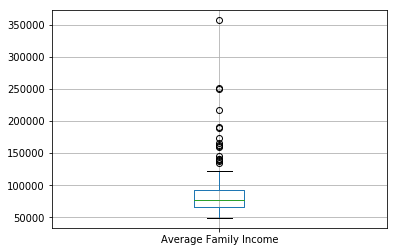

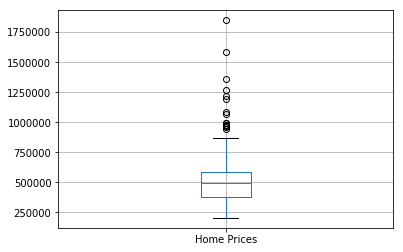

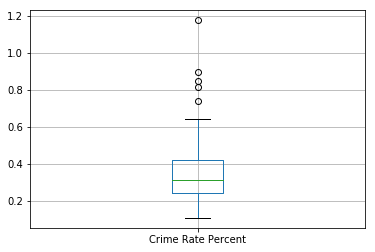

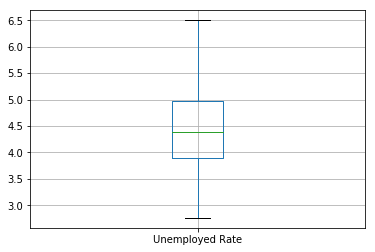

In [27]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 24))
for column in df_box:
    plt.figure()
    df_box.boxplot([column])
plt.show()

... We filter 'affluent' neighbourhoods as those in the 4th or top quartile measures of 'Average Family Income' and 'Home Prices'.    
... We filter 'super affluent' neighbourhoods as those in the outliers in the measures of 'Average family income' and 'Home Prices'.    
... We filter 'safe' neighbourhoods as those in the first quartile of bottom quartile measured by 'Crime Rate' and 'Unemployed Rate'.  

### Next we find these neighbourhoods and check against the foursquare trending data and locate concentration of ethnic restaurants already in place. A last filter is to check the concentration of ethnic groups in the safe and affluent neighbourhoods. 


In [19]:
df_ethnic_group.head()

,Neighbourhood,Total Population,Visible Minority Category,Chinese,Korean,Japanese
0,West Humber-Clairville,33312.0,32890.0,470.0,60.0,60.0
1,Mount Olive-Silverstone-Jamestown,32954.0,32830.0,285.0,70.0,10.0
2,Thistletown-Beaumond Heights,10360.0,10125.0,110.0,40.0,15.0
3,Rexdale-Kipling,10529.0,10360.0,165.0,10.0,35.0
4,Elms-Old Rexdale,9456.0,9445.0,105.0,105.0,15.0


In [20]:
df_ethnic_group.describe()

,Total Population,Visible Minority Category,Chinese,Korean,Japanese
count,140.000000,140.000000,140.000000,140.000000,140.00000
mean,19511.221429,19226.571429,2139.178571,297.500000,96.00000
std,10033.589222,9942.217973,3526.503282,572.521402,89.73422
min,6577.000000,6370.000000,100.000000,0.000000,0.00000
25%,12019.500000,11970.000000,448.750000,58.750000,38.75000
50%,16749.500000,16532.500000,840.000000,130.000000,70.00000
75%,23854.500000,23507.500000,1955.000000,258.750000,126.25000
max,65913.000000,65620.000000,18715.000000,5255.000000,665.00000


In [21]:
df_ethnic_group['e_asians'] = df_ethnic_group['Chinese'] + df_ethnic_group['Korean'] + df_ethnic_group['Japanese']
df_ethnic_group.head()

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Neighbourhood,Total Population,Visible Minority Category,Chinese,Korean,Japanese,e_asians
0,West Humber-Clairville,33312.0,32890.0,470.0,60.0,60.0,590.0
1,Mount Olive-Silverstone-Jamestown,32954.0,32830.0,285.0,70.0,10.0,365.0
2,Thistletown-Beaumond Heights,10360.0,10125.0,110.0,40.0,15.0,165.0
3,Rexdale-Kipling,10529.0,10360.0,165.0,10.0,35.0,210.0
4,Elms-Old Rexdale,9456.0,9445.0,105.0,105.0,15.0,225.0


In [22]:
# e_asians as percent of 'visible minority category'
df_ethnic_group['e_asian_percent'] = 100*(df_ethnic_group['e_asians'])/(df_ethnic_group['Visible Minority Category'])
df_ethnic_group.head()

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Neighbourhood,Total Population,Visible Minority Category,Chinese,Korean,Japanese,e_asians,e_asian_percent
0,West Humber-Clairville,33312.0,32890.0,470.0,60.0,60.0,590.0,1.793858
1,Mount Olive-Silverstone-Jamestown,32954.0,32830.0,285.0,70.0,10.0,365.0,1.111788
2,Thistletown-Beaumond Heights,10360.0,10125.0,110.0,40.0,15.0,165.0,1.629630
3,Rexdale-Kipling,10529.0,10360.0,165.0,10.0,35.0,210.0,2.027027
4,Elms-Old Rexdale,9456.0,9445.0,105.0,105.0,15.0,225.0,2.382213


In [23]:
df_ethnic_group.describe()

,Total Population,Visible Minority Category,Chinese,Korean,Japanese,e_asians,e_asian_percent
count,140.000000,140.000000,140.000000,140.000000,140.00000,140.000000,140.000000
mean,19511.221429,19226.571429,2139.178571,297.500000,96.00000,2532.678571,11.621524
std,10033.589222,9942.217973,3526.503282,572.521402,89.73422,3840.514448,13.607949
min,6577.000000,6370.000000,100.000000,0.000000,0.00000,125.000000,1.111788
25%,12019.500000,11970.000000,448.750000,58.750000,38.75000,610.000000,4.015556
50%,16749.500000,16532.500000,840.000000,130.000000,70.00000,1037.500000,6.846604
75%,23854.500000,23507.500000,1955.000000,258.750000,126.25000,2432.500000,11.323194
max,65913.000000,65620.000000,18715.000000,5255.000000,665.00000,22900.000000,73.913043


In [24]:
df_box_ethnic = df_ethnic_group[['Chinese','Korean','Japanese']]
df_box_ethnic.head()

,Chinese,Korean,Japanese
0,470.0,60.0,60.0
1,285.0,70.0,10.0
2,110.0,40.0,15.0
3,165.0,10.0,35.0
4,105.0,105.0,15.0


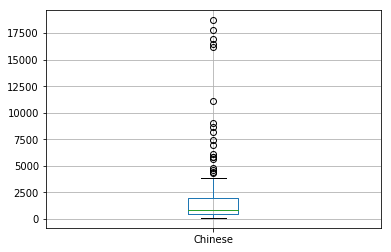

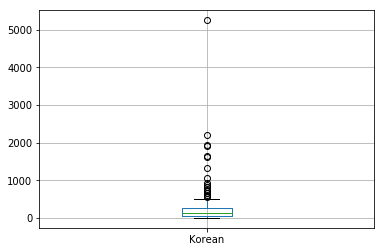

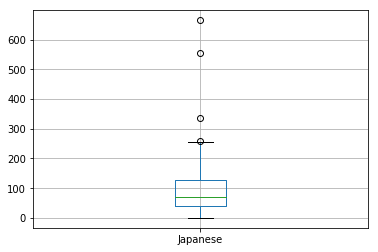

In [25]:
fig = plt.figure(figsize=(16,24))
for column in df_box_ethnic:
    plt.figure()
    df_box_ethnic.boxplot([column])
    plt.show()


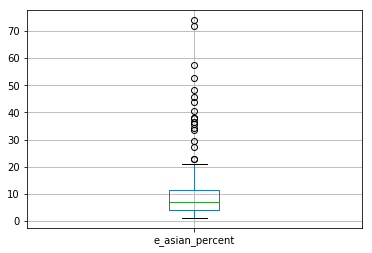

In [26]:
df_ethnic_group.boxplot(column=['e_asian_percent'])

### We target to locate in neighbourhoods where east asians are in top quartile of "east_asians as percent of visible minority category"



### Find the neighbourhoods meeting filters criteria


In [28]:
print(df_ethnic_group['Neighbourhood'])

0                 West Humber-Clairville
1      Mount Olive-Silverstone-Jamestown
2           Thistletown-Beaumond Heights
3                        Rexdale-Kipling
4                       Elms-Old Rexdale
5          Kingsview Village-The Westway
6       Willowridge-Martingrove-Richview
7               Humber Heights-Westmount
8               Edenbridge-Humber Valley
9                     Princess-Rosethorn
10        Eringate-Centennial-West Deane
11                         Markland Wood
12                   Etobicoke West Mall
13            Islington-City Centre West
14                        Kingsway South
15                   Stonegate-Queensway
16                                Mimico
17                           New Toronto
18                           Long Branch
19                             Alderwood
20                         Humber Summit
21                            Humbermede
22                  Pelmo Park-Humberlea
23                           Black Creek
24              

In [31]:
# Filter for affluent neighbourhoods
condition_1 = df_inc_emp2['Average Family Income'] >= 92803.75
condition_2 = df_inc_emp2['Home Prices'] >= 590216.00
df_affluent = df_inc_emp2.loc[condition_1 & condition_2]
df_affluent.head()

,Neighbourhood,Total Population,Average Family Income,Home Prices,Crime Rate Percent,Unemployed Rate
8,Edenbridge-Humber Valley,15535.0,119581.0,873268,0.315417,3.282910
9,Princess-Rosethorn,11051.0,144943.0,971668,0.479595,3.212379
14,Kingsway South,9271.0,191204.0,941223,0.377521,3.883076
15,Stonegate-Queensway,25051.0,100867.0,690949,0.247495,3.732386
37,Lansing-Westgate,16164.0,105947.0,646460,0.309329,4.114081


In [32]:
#Filter for safe neighbourhoods
condition_3 = df_inc_emp2['Crime Rate Percent'] <= 0.242904
condition_4 = df_inc_emp2['Unemployed Rate'] <= 3.894406
df_safe = df_inc_emp2.loc[condition_3 & condition_4]
df_safe.head()

,Neighbourhood,Total Population,Average Family Income,Home Prices,Crime Rate Percent,Unemployed Rate
16,Mimico,33964.0,87901.0,429941,0.161936,3.842304
27,Rustic,9941.0,59004.0,493442,0.211246,3.772256
41,Banbury-Don Mills,27695.0,115239.0,613647,0.241921,3.646868
55,Leaside-Bennington,16828.0,158847.0,1071823,0.237699,3.773473
86,High Park-Swansea,23925.0,116465.0,622206,0.217346,3.615465


In [33]:
# Desirable safe and affluent neighbourhoods are at intersection of df_affluent and df_safe
df_safe_affluent = pd.merge(df_safe, df_affluent, how='inner', on=['Neighbourhood']) 
df_safe_affluent.head()

,Neighbourhood,Total Population_x,Average Family Income_x,Home Prices_x,Crime Rate Percent_x,Unemployed Rate_x,Total Population_y,Average Family Income_y,Home Prices_y,Crime Rate Percent_y,Unemployed Rate_y
0,Banbury-Don Mills,27695.0,115239.0,613647,0.241921,3.646868,27695.0,115239.0,613647,0.241921,3.646868
1,Leaside-Bennington,16828.0,158847.0,1071823,0.237699,3.773473,16828.0,158847.0,1071823,0.237699,3.773473
2,High Park-Swansea,23925.0,116465.0,622206,0.217346,3.615465,23925.0,116465.0,622206,0.217346,3.615465
3,Casa Loma,10968.0,188924.0,1083381,0.182349,3.874909,10968.0,188924.0,1083381,0.182349,3.874909
4,Yonge-St.Clair,12528.0,173751.0,995616,0.143678,3.631865,12528.0,173751.0,995616,0.143678,3.631865


In [34]:
len(df_safe_affluent)

6

In [35]:
# df with top quartile e_asians presence
df_e_asians = df_ethnic_group[df_ethnic_group['e_asian_percent']>= 11.323]
df_e_asians.head()

,Neighbourhood,Total Population,Visible Minority Category,Chinese,Korean,Japanese,e_asians,e_asian_percent
35,Newtonbrook West,23831.0,23620.0,2650.0,2210.0,100.0,4960.0,20.999153
36,Willowdale West,16936.0,16670.0,3655.0,1930.0,145.0,5730.0,34.373125
37,Lansing-Westgate,16164.0,16065.0,1740.0,875.0,70.0,2685.0,16.713352
39,St.Andrew-Windfields,17812.0,17675.0,3845.0,820.0,145.0,4810.0,27.213579
40,Bridle Path-Sunnybrook-York Mills,9266.0,9185.0,1410.0,185.0,55.0,1650.0,17.964072


In [39]:
len(df_e_asians)

35

In [38]:
# neighbourhoods with safe,affluent and e_asians presence
df_chosen = pd.merge(df_safe_affluent, df_e_asians, how = 'inner', on=['Neighbourhood'])
df_chosen.head()

,Neighbourhood,Total Population_x,Average Family Income_x,Home Prices_x,Crime Rate Percent_x,Unemployed Rate_x,Total Population_y,Average Family Income_y,Home Prices_y,Crime Rate Percent_y,Unemployed Rate_y,Total Population,Visible Minority Category,Chinese,Korean,Japanese,e_asians,e_asian_percent
0,Banbury-Don Mills,27695.0,115239.0,613647,0.241921,3.646868,27695.0,115239.0,613647,0.241921,3.646868,27695.0,26995.0,4630.0,560.0,210.0,5400.0,20.003704


## Filters selected one neighbourhood which meets safe, affluent and high e_asians presence criteria, Banbury-Don Mills

## Next use Foursquare API to check the trending traffic and restaurants in Branbury-Don Mills neighbourhood

In [46]:
# Get geographical coordinates of Branbury-Don Mills
from geopy.geocoders import Nominatim
address = 'Banbury-Don Mills, Toronto'
geolocator= Nominatim(user_agent = 'ont_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The Geographical coordinates of Banbury-Don Mills are {},{}.'.format (latitude,longitude))

The Geographical coordinates of Banbury-Don Mills are 43.7348039,-79.3572426.


In [49]:
# create map of neighbourhood
!pip install folium
import folium
map_banbury_dm = folium.Map(location = [latitude, longitude], zoom_start =11)
map_banbury_dm

tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
